In [1]:
!pip install rapidfuzz yfinance pandas numpy nltk scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import re
from collections import Counter

import numpy as np
import pandas as pd
import yfinance as yf

import nltk
from rapidfuzz import fuzz, process

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


In [3]:
# load SEC(https://www.sec.gov/files/company_tickers.json) tickers
with open("tickers.json", "r") as f:
    tickers = json.load(f)
    companies = [tickers[i]["title"] for i in tickers]
    abbrs = [tickers[i]["ticker"] for i in tickers]

    comp_tckr = {comp: abbr for comp, abbr in zip(companies, abbrs)}

# load recall data
df = pd.read_csv("recalls.csv")

## Data Cleaning

In [4]:
# delete instances where year is older than 1995
print(len(df))
for i, row in df.iterrows():
    if ( row['Report Received Date'][-4:].isnumeric() and int(row['Report Received Date'][-4:]) < 1995 ):
        df.drop(i, inplace=True)
print(len(df))

29374
22505


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22505 entries, 0 to 23952
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Report Received Date                      22505 non-null  object 
 1   NHTSA ID                                  22505 non-null  object 
 2   Recall Link                               22505 non-null  object 
 3   Manufacturer                              22505 non-null  object 
 4   Subject                                   22505 non-null  object 
 5   Component                                 16196 non-null  object 
 6   Mfr Campaign Number                       22362 non-null  object 
 7   Recall Type                               22505 non-null  object 
 8   Potentially Affected                      22505 non-null  int64  
 9   Recall Description                        22500 non-null  object 
 10  Consequence Summary                    

In [6]:
# get set of common words to ignore
stop_words = set([
    "inc", "corp", "llc", "co", "ltd", "corporation",
    "company", "limited", "plc", "gmbh", "sa", "ag", "pte", "bv", "kg", "kgaa", "corp", "industries", "us", "of"
])

# create tokenizer
def tokenize(name):
    name = name.lower()
    name = re.sub(r'[^a-z0-9 ]', ' ', name) 
    words = name.split()
    return [w for w in words if w not in stop_words]

# build a word-to-company mapping
word_counts = Counter()
company_word_map = {}
for c in companies:
    words = tokenize(c)
    company_word_map[c] = set(words)
    word_counts.update(words)

# match company to ticker by unique words
def match_by_unique_words(name):
    words = tokenize(name)
    if not words:
        return None
    
    # score companies by sum of inverse word frequencies (rare words are more valuable)
    scores = {}
    for c, c_words in company_word_map.items():
        score = sum(1 / word_counts[w] for w in words if w in c_words)
        if score > 0:
            scores[c] = score
    
    if scores:
        return max(scores, key=scores.get)
    return None

"""df.loc[:22505, "fuzzy_company"] = df.loc[:22505, "Manufacturer"].apply(match_by_unique_words)"""

'df.loc[:22505, "fuzzy_company"] = df.loc[:22505, "Manufacturer"].apply(match_by_unique_words)'

In [7]:
# match the company to the ticker symbol
tickers = pd.read_csv("manualTickers.csv")
df = df.merge(tickers, left_on="Manufacturer", right_on="Manufacturer Name", how="left")

In [8]:
df

,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action,Park Outside Advisory,Do Not Drive Advisory,Completion Rate % (Blank - Not Reported),Stock Abbreviation,Opening Stock Value,Closing Stock Value,Manufacturer Name,Abbreviation
0,10/01/2025,25V656000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Toyota Motor Engineering & Manufacturing,Driveshaft May Deform and Break,POWER TRAIN,25TB11 / 25TA11,Vehicle,5960,Toyota Motor Engineering & Manufacturing (Toyo...,A broken driveshaft can impair steering. Vehic...,Dealers will inspect and replace both front dr...,No,No,NaN,NYSE:TM,192.39,191.83,Toyota Motor Engineering & Manufacturing,TM
1,10/01/2025,25V655000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Nissan North America, Inc.",Fire Risk from Quick Charging Battery,ELECTRICAL SYSTEM,R25C8,Vehicle,19077,"Nissan North America, Inc. (Nissan) is recalli...",A quick charging battery that overheats increa...,Owners are advised not to use Level 3 quick ch...,No,No,NaN,NYSE:NSANY,NaN,NaN,"Nissan North America, Inc.",NSANY
2,09/30/2025,25V654000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Volvo Car USA, LLC",Power Operated Tailgate May Drop Suddenly,STRUCTURE,R10342,Vehicle,1119,"Volvo Car USA, LLC (Volvo) is recalling certai...",A tailgate that suddenly drops can hit a perso...,Owners are advised not to use the POT function...,No,No,NaN,NYSE:,NaN,NaN,"Volvo Car USA, LLC",VLVLY
3,09/30/2025,25V653000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Thor Motor Coach,LP Tank May Detach and Become a Road Hazard,EQUIPMENT,RC000331,Vehicle,23,Thor Motor Coach (TMC) is recalling certain 20...,A detached tank can create a road hazard for o...,The remedy is currently under development. Own...,No,No,NaN,NYSE:,NaN,NaN,Thor Motor Coach,THO
4,09/26/2025,25E062000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"MEDIX SPECIALTY VEHICLES, INC.",Quick Liner Wheel Covers May Detach and Become...,WHEELS,NaN,Equipment,396,"Medix Specialty Vehicles, Inc. (Medix) is reca...",A detached cover can create a road hazard for ...,"Medix will replace the covers, free of charge....",No,No,NaN,NYSE:,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22500,01/11/1995,95V004000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"THOMAS BUILT BUSES, INC.",INTERIOR SYSTEMS:ACTIVE RESTRAINTS:BELT RETRAC...,SEAT BELTS,NR (Not Reported),Vehicle,3076,THE METAL HOUSING OF THE SAFETY BELT RETRACTOR...,PASSENGERS WOULD BE UNABLE TO EXTEND OR RETRAC...,DEALERS WILL INSTALL A HARDENED WASHER WHICH W...,No,No,NaN,NYSE:,NaN,NaN,"THOMAS BUILT BUSES, INC.",NaN
22501,01/03/1995,95T001000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Cooper Tire & Rubber Co.,TIRES:MARKINGS,TIRES,NR (Not Reported),Tire,6603,THE MAXIMUM INFLATION PRESSURE STAMPING ON THE...,NaN,DEALERS WILL REPLACE THE INCORRECT TIRES WITH ...,No,No,NaN,NYSE:,NaN,NaN,Cooper Tire & Rubber Co.,GT
22502,01/03/1995,95V013000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"PREVOST CAR, INC. Inactive",STRUCTURE:DOOR ASSEMBLY,STRUCTURE,NR (Not Reported),Vehicle,1090,IF A PASSENGER TRIES TO EXIT THE LAVATORY COMP...,"IF THE WINDOW SEPARATES, THE OCCUPANT CAN FALL...",DEALERS WILL INSTALL A RAIL IN THE LAVATORY CO...,No,No,NaN,NYSE:,NaN,NaN,"PREVOST CAR, INC. Inactive",NaN
22503,01/03/1995,95V016000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"PREVOST CAR, INC. Inactive",EMERGENCY PARKING BRAKE:MECHANICAL,PARKING BRAKE,NR (Not Reported),Vehicle,2075,THE PARKING BRAKE BUTTON CAN BE HIT ACCIDENTLY...,UNINTENDED OPERATION OF THE PARKING BRAKE BUTT...,DEALERS WILL INSTALL A PROTECTOR OVER THE PARK...,No,No,NaN,NYSE:,NaN,NaN,"PREVOST CAR, INC. Inactive",NaN


In [9]:
"""# get stock ticker
df["ticker"] = df["fuzzy_company"].map(comp_tckr)"""

# convert to datetime
df["Report Received Date"] = pd.to_datetime(df["Report Received Date"])

# get unique tickers
unique_tickers = df["Abbreviation"].astype(str).unique().tolist()

# get all prices in range (start of day, end of day)
start_date = df["Report Received Date"].min()
end_date = df["Report Received Date"].max() + pd.Timedelta(days=1)
price_data = yf.download(unique_tickers, start=start_date, end=end_date, group_by="Abbreviation", progress=False)

# helper function to grab pricing data
def get_price(ticker, date):
    try:
        day_data = price_data[ticker].loc[date.strftime("%Y-%m-%d")]
        return pd.Series([day_data["Open"], day_data["Close"]])
    except Exception:
        return pd.Series([None, None])

# get open/close price
df[["open", "close"]] = df.apply(lambda x: get_price(x["Abbreviation"], x["Report Received Date"]), axis=1)

# grab info on ticker
info_cache = {}
for ticker in unique_tickers:
    try:
        t = yf.Ticker(ticker)
        info = t.info
        info_cache[ticker] = {
            "market_cap": info.get("marketCap"),
            "eps": info.get("trailingEps"),
            "full_name": info.get("longName"),
            "yearhigh": info.get("fiftyTwoWeekHigh"),
            "yearlow": info.get("firftyTwoWeekLow"),
            "volumnet": info.get("volume")
        }
    except Exception:
        pass

# merge info back on ticker
info_df = pd.DataFrame(info_cache).T
info_df.index.name = "Abbreviation"
df = df.merge(info_df, on="Abbreviation", how="left")


C:\Users\Crook\AppData\Local\Temp\ipykernel_41540\406290391.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(unique_tickers, start=start_date, end=end_date, group_by="Abbreviation", progress=False)
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: PALF"}}}
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: HYMTF"}}}

42 Failed downloads:
['HYMTF', 'PALF', 'SSDIY', 'SOLO', 'MTOR', 'AML:LSE', '601966', 'HZN', 'BRK.B', 'ML', '600248', 'BRK.A', 'ZEV', 'SHYF', 'CGCYF', 'TRATON', '1319', 'FSR', 'PIRC', 'LEV', 'HILLY', 'LLAPW', 'PTRAQ', 'VNE', 'TTM', '$CRMT', 'VEV', 'KTMPF', 'FUV', 'NKLA', 'BMWYY', 'HAHSY', 'GEM.V', 'EONE', 'NAV']: YFTzMissingError('possibly delisted; no timezone found')
['HLDXF', 'DWL', 'MOTR', 'ZOOX', 'KRW', 'KZ']: YFPricesMissingError('possibly delisted; no price data found  (1d

In [10]:
df

,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,...,Manufacturer Name,Abbreviation,open,close,market_cap,eps,full_name,yearhigh,yearlow,volumnet
0,2025-10-01,25V656000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Toyota Motor Engineering & Manufacturing,Driveshaft May Deform and Break,POWER TRAIN,25TB11 / 25TA11,Vehicle,5960,Toyota Motor Engineering & Manufacturing (Toyo...,...,Toyota Motor Engineering & Manufacturing,TM,192.389999,191.830002,257565818880,22.47,Toyota Motor Corporation,211.24,None,394869
1,2025-10-01,25V655000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Nissan North America, Inc.",Fire Risk from Quick Charging Battery,ELECTRICAL SYSTEM,R25C8,Vehicle,19077,"Nissan North America, Inc. (Nissan) is recalli...",...,"Nissan North America, Inc.",NSANY,5.020000,4.840000,8162550272,-3.25,"Nissan Motor Co., Ltd.",7.11,None,19374
2,2025-09-30,25V654000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Volvo Car USA, LLC",Power Operated Tailgate May Drop Suddenly,STRUCTURE,R10342,Vehicle,1119,"Volvo Car USA, LLC (Volvo) is recalling certai...",...,"Volvo Car USA, LLC",VLVLY,28.500000,28.690001,57648365568,1.83,AB Volvo (publ),33.33,None,24418
3,2025-09-30,25V653000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Thor Motor Coach,LP Tank May Detach and Become a Road Hazard,EQUIPMENT,RC000331,Vehicle,23,Thor Motor Coach (TMC) is recalling certain 20...,...,Thor Motor Coach,THO,104.544860,103.191399,5330364416,4.84,"THOR Industries, Inc.",118.85,None,546604
4,2025-09-26,25E062000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"MEDIX SPECIALTY VEHICLES, INC.",Quick Liner Wheel Covers May Detach and Become...,WHEELS,NaN,Equipment,396,"Medix Specialty Vehicles, Inc. (Medix) is reca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22500,1995-01-11,95V004000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"THOMAS BUILT BUSES, INC.",INTERIOR SYSTEMS:ACTIVE RESTRAINTS:BELT RETRAC...,SEAT BELTS,NR (Not Reported),Vehicle,3076,THE METAL HOUSING OF THE SAFETY BELT RETRACTOR...,...,"THOMAS BUILT BUSES, INC.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22501,1995-01-03,95T001000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Cooper Tire & Rubber Co.,TIRES:MARKINGS,TIRES,NR (Not Reported),Tire,6603,THE MAXIMUM INFLATION PRESSURE STAMPING ON THE...,...,Cooper Tire & Rubber Co.,GT,23.432037,23.694336,2317903360,-6.02,The Goodyear Tire & Rubber Company,12.03,None,7743022
22502,1995-01-03,95V013000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"PREVOST CAR, INC. Inactive",STRUCTURE:DOOR ASSEMBLY,STRUCTURE,NR (Not Reported),Vehicle,1090,IF A PASSENGER TRIES TO EXIT THE LAVATORY COMP...,...,"PREVOST CAR, INC. Inactive",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22503,1995-01-03,95V016000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"PREVOST CAR, INC. Inactive",EMERGENCY PARKING BRAKE:MECHANICAL,PARKING BRAKE,NR (Not Reported),Vehicle,2075,THE PARKING BRAKE BUTTON CAN BE HIT ACCIDENTLY...,...,"PREVOST CAR, INC. Inactive",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def ba_rm_nulls(df=None, col=None):
    """ 
    Helper function to print length of dataframe before removing nulls in a column, then print the length after the nulls are removed.

    Args:
        * df (pd.DataFrame): Dataframe with nulls.
        * col (str): Column name nulls should be removed from.

    Returns:
        * df (pd.DataFrame): Dataframe without nulls.
    """

    print(f"BEFORE NULLS FROM {col} REMOVED: ", len(df))

    df = df[df[f"{col}"].notna()]

    print(f"AFTER NULLS FROM {col} REMOVED: ", len(df))

    return df

In [12]:
df = ba_rm_nulls(df, "Abbreviation")

BEFORE NULLS FROM Abbreviation REMOVED:  22505
AFTER NULLS FROM Abbreviation REMOVED:  15115


In [13]:
df = ba_rm_nulls(df, "Recall Description")
df = ba_rm_nulls(df, "Corrective Action")

BEFORE NULLS FROM Recall Description REMOVED:  15115
AFTER NULLS FROM Recall Description REMOVED:  15113
BEFORE NULLS FROM Corrective Action REMOVED:  15113
AFTER NULLS FROM Corrective Action REMOVED:  15112


In [ ]:
"""exclude_list = ['MCW', 'GAERF', 'BACRP', 'CRL', 'BBAAY', 'LBRJ', 'FIX', 'UFCS', 'BNS', 'TFIN-P']
df = df[~df['ticker'].isin(exclude_list)]"""

In [ ]:
"""include_list = ['GM', 'STLA', 'TOYOF', 'F-PD']
df = df[~df['ticker'].isin(include_list)]"""

In [14]:
print(len(df))

15112


In [ ]:
#df.to_csv('ticker_test2.csv')

### Get Dummies

In [15]:
# see num of dummies from col types
print(len(df.value_counts("Recall Type")))
print(len(df.value_counts("Component")))

4
35


In [16]:
# fill missing components
df['Original_Component'] = df['Component'].fillna('')

In [17]:
# create dummies for recall and components
df = pd.get_dummies(data=df, prefix="RECALL_TYPE_", columns=["Recall Type"])
df = pd.get_dummies(data=df, prefix="COMPONENT_TYPE_", columns=["Component"])

### Bag of Words Featuring 

In [18]:
# init recall vectorizer
recall_vectorizer = CountVectorizer(
    input='content',    
    stop_words='english',
    analyzer='word',
    decode_error='ignore'
)

# init component vectorizer
component_vectorizer = CountVectorizer(
    input='content',    
    stop_words='english',
    analyzer='word',
    decode_error='ignore'
)

# init compnay response vectorizer
corrective_action_vectorizer = CountVectorizer(
    input='content',    
    stop_words='english',
    analyzer='word',
    decode_error='ignore'
)

In [19]:
# ensure component type is string
df["Original_Component"] = df["Original_Component"].astype(str)

In [20]:
# get bow for the diff cols
X_recall = recall_vectorizer.fit_transform(df["Recall Description"])
X_component = component_vectorizer.fit_transform(df["Original_Component"])
X_corrective_action = corrective_action_vectorizer.fit_transform(df["Corrective Action"])

In [21]:
df['Report Received Date'] = pd.to_datetime(df['Report Received Date'])

In [22]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

df["pct_of_yearly_max"] = np.clip(df["open"]/df["yearhigh"])
df["yearly_min_pct_of"] = np.clip(df["yearlow"] / df["open"], 0, 1)

N_COMPONENTS = 20   
K = 5          

# convert to dense matrix
X_recall_dense = X_recall.toarray()
X_component_dense = X_component.toarray()
X_corrective_dense = X_corrective_action.toarray()

# aplpy pca
pca = PCA(n_components=N_COMPONENTS, random_state=42)

X_recall_pca = pca.fit_transform(X_recall_dense)
X_component_pca = pca.fit_transform(X_component_dense)
X_corrective_pca = pca.fit_transform(X_corrective_dense)


def gmm_fixed_k(X, k=5, random_state=42):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='diag',  
        random_state=random_state
    )
    labels = gmm.fit_predict(X)
    return gmm, labels


print("\nClustering Recall...")
recall_model, recall_labels = gmm_fixed_k(X_recall_pca, K)

print("Clustering Component...")
component_model, component_labels = gmm_fixed_k(X_component_pca, K)

print("Clustering Corrective Action...")
corrective_model, corrective_labels = gmm_fixed_k(X_corrective_pca, K)

# Add to df
df["recall_cluster"] = recall_labels
df["component_cluster"] = component_labels
df["corrective_action_cluster"] = corrective_labels


Clustering Recall...
Clustering Component...
Clustering Corrective Action...


In [23]:
# save for faster processing
df.to_csv('intermediate.csv')
df = pd.read_csv("intermediate.csv")

### Build Baseline Model

In [24]:
df = pd.read_csv("intermediate.csv")

In [25]:
#df = df[df['Potentially Affected'] <=1000000] #TODO temp comment out

# stock market is generally in terms of %P/L. the reason being is who cares if i have 10 shares that are each $1000 and it moves a dollar
# in this case, i'd gain or lose $10.
# meanwhile, if i have 1000 shares at $10/each and it moves a dollar, i'd gain or lose $1000
df["pct_change"] = 100 * ((df["close"] - df["open"]) / df["open"])
df = df[(df["pct_change"] > -200) & (df["pct_change"] < 200) & df["pct_change"] != 0]

# determine target
y_NULL=df["pct_change"]

# features
X_NULL = df["Potentially Affected"].values

In [26]:
# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_NULL, y_NULL, test_size=0.2, random_state=24)

In [27]:
print("X_train_shape:", X_train.shape)
print("X_test_shape:", X_test.shape)
print("y_train_shape:", y_train.shape)
print("y_test_shape:", y_test.shape )

X_train_shape: (7059,)
X_test_shape: (1765,)
y_train_shape: (7059,)
y_test_shape: (1765,)


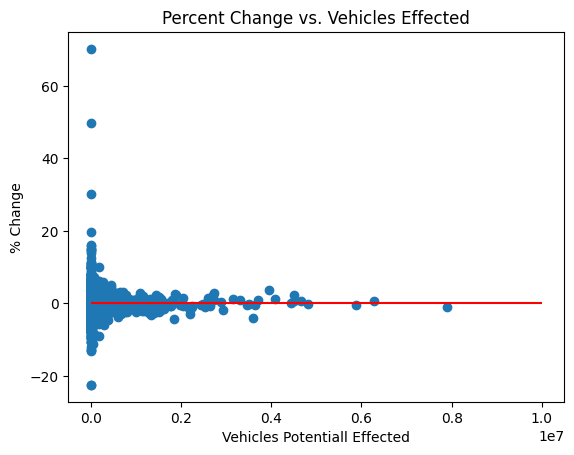

In [28]:
plt.scatter(X_NULL, y_NULL )
plt.xlabel("Vehicles Potentiall Effected")
plt.ylabel("% Change")
plt.title("Percent Change vs. Vehicles Effected")
plt.hlines(y=0, xmin=0, xmax=10000000, linestyles='solid', colors="red")
plt.show()

In [29]:
# turn yes/no cols to be bools
cols_w_yn = ["Park Outside Advisory", "Do Not Drive Advisory"]
df[cols_w_yn] = df[cols_w_yn].replace({"Yes": 1, "No": 0})

# get engineered features
features = ["Potentially Affected", "Park Outside Advisory", "Do Not Drive Advisory", "market_cap", "eps"]
df[features] = df[features].astype(float).fillna(0)

C:\Users\Crook\AppData\Local\Temp\ipykernel_41540\1908037100.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols_w_yn] = df[cols_w_yn].replace({"Yes": 1, "No": 0})


In [30]:
# scale cols with crazy magnitudes
scaler = StandardScaler()
non_bool_feats = ["Potentially Affected", "market_cap", "eps"]
df[non_bool_feats] = scaler.fit_transform(df[non_bool_feats])

# get features and target
X = df[features]
y = df['pct_change']

# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_NULL, y_NULL, test_size=0.2, random_state=24)


In [31]:
# train linear regression
lr = LinearRegression()
lr.fit(X, y)

# predict using linear regression
y_pred = lr.predict(X)

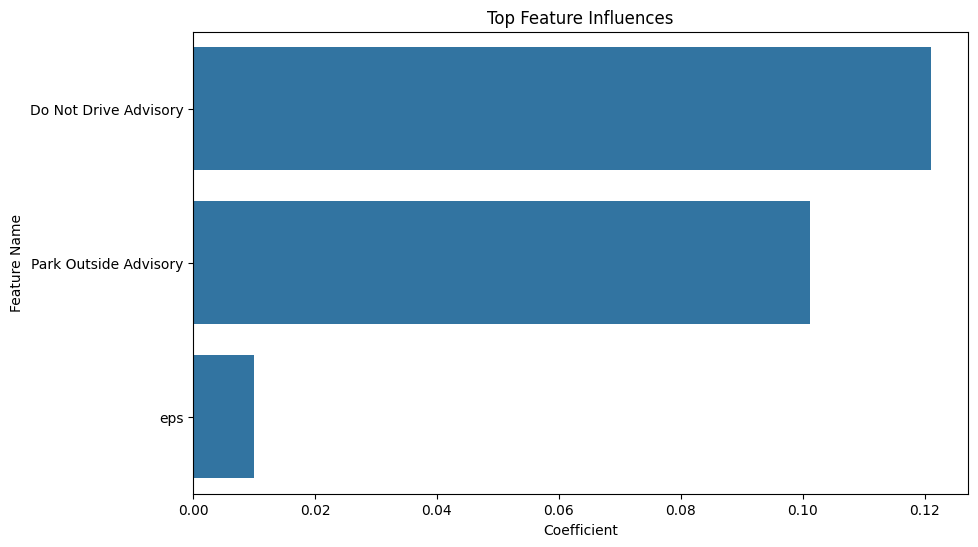

In [32]:
# get all feature coefficients from the trained model
coef_df = pd.DataFrame({
    'feature': features,
    'coef': lr.coef_
})

# plot values to see feature importances
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coef_df.head(3), x='abs_coef', y='feature')
plt.title("Top Feature Influences")
plt.xlabel("Coefficient")
plt.ylabel("Feature Name")
plt.show()


In [33]:
# get predictive metrics for evaluation
r2 = r2_score(y, y_pred)
print("R squared:", r2)


R squared: 9.176562127444221e-05


In [34]:
pd.DataFrame({
    "y": y,
    "y_pred": y_pred
})

,y,y_pred
0,-0.291074,-0.002592
1,-3.585654,0.014215
2,0.666669,0.011108
3,-1.294622,0.014616
6,-0.562724,0.009274
...,...,...
15101,4.444427,0.014381
15102,4.444427,0.014392
15105,-0.840336,0.014497
15106,-0.483091,0.011532


### Can We Predict +/-?

In [35]:
# get features and target
X = df[features]
df["inc_dec"] = np.where(df["pct_change"] > 0, 1, 0)
y = df['inc_dec']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [37]:
y_pred = np.zeros_like(y_test)

# get predictive metrics for evaluation
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.5008498583569405


# Model Specification

## Random Forest Regressor

In [38]:
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [39]:
rf = RandomForestRegressor(random_state=24)

In [40]:
features = [
    "Potentially Affected",
    "Park Outside Advisory",
    "Do Not Drive Advisory",
    "market_cap",
    "eps",
    "pct_of_yearly_max"
] + [col for col in df.columns if col.startswith(('COMPONENT_TYPE', 'RECALL_TYPE')) or col.endswith('cluster')]

# fill missing for base features
df[features] = df[features].astype(float).apply(lambda col: col.fillna(col.mean()))

# final feature matrix
X = df[features]
y = df["pct_change"]



In [41]:
# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [43]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    random_state=42,
)

rf_random.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=24)
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [44]:
# print("Best hyperparameters:", rf_random.best_params_)
# print("Best CV R squared:", rf_random.best_score_)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R squared:", r2)

Test MSE: 3.92358332933757
Test R squared: 0.0028811093529431675


In [45]:
from sklearn.tree import DecisionTreeClassifier
# binary target: up (1) or down (0)
y_train_cls = (y_train > 0).astype(int)
y_test_cls  = (y_test > 0).astype(int)

tree_clf = DecisionTreeClassifier(random_state=24)

tree_clf.fit(X_train, y_train_cls)

y_pred_cls = tree_clf.predict(X_test)

acc = accuracy_score(y_test_cls, y_pred_cls)

print("Decision Tree Accuracy:", acc)


Decision Tree Accuracy: 0.5337110481586402


In [46]:
features = [
    "Potentially Affected",
    "Park Outside Advisory",
    "Do Not Drive Advisory",
    "market_cap",
    "eps",
    "pct_of_yearly_max"
] + [col for col in df.columns if col.startswith(('COMPONENT_TYPE', 'RECALL_TYPE')) or col.endswith('cluster')]

# fill missing for base features
df[features] = df[features].astype(float).apply(lambda col: col.fillna(col.mean()))


test = df.copy()

# final feature matrix
X = test[features]
y = test["pct_change"]


In [47]:
# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
y_train_abs = abs(y_train)

In [48]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import numpy as np

# ---------------------------
# 1. CLASSIFICATION: DETERMINE SIGN
# ---------------------------
y_train_cls = (y_train > 0).astype(int)
y_test_cls = (y_test > 0).astype(int)

tree_clf = DecisionTreeClassifier(random_state=24)
tree_clf.fit(X_train, y_train_cls)

y_pred_cls = tree_clf.predict(X_test)
acc = accuracy_score(y_test_cls, y_pred_cls)
print("Decision Tree Accuracy:", acc)

# ---------------------------
# 2. REGRESSION: DETERMINE MAGNITUDE
# ---------------------------
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),   
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', Ridge(alpha=0.1, max_iter=10000)) 
])

model.fit(X_train, y_train_abs) 
y_pred_reg = model.predict(X_test)

# ---------------------------
# 3. COMBINE SIGN AND MAGNITUDE
# ---------------------------
sign = np.where(y_pred_cls == 1, 1, -1)
final_pred = y_pred_reg * sign

# ---------------------------
# 4. EVALUATION
# ---------------------------
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print("Test MSE:", mse)
print("Test R^2:", r2)


Decision Tree Accuracy: 0.5337110481586402
Test MSE: 5.440690663917007
Test R^2: -0.3826685924049551
